In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
R = {'A': ['a', 'b', 'c'],
     'B': ['b', 'd', 'e', 'f', 'g'],
     'C': ['a', 'c', 'd', 'e', 'h'],
     'D': ['b', 'd', 'i', 'j']}

In [3]:
items = []
for r in R.values():
    for a in r:
        if a not in items:
            items.append(a)

In [4]:
M = np.zeros([len(R), len(items)])

In [5]:
for k, v in R.items():
    row = ord(k) - ord('A')
    idx = [ord(c) - ord('a') for c in v]
    M[row, idx] = 1

In [6]:
pairwise_distances(M)

array([[0.        , 2.44948974, 2.        , 2.23606798],
       [2.44948974, 0.        , 2.44948974, 2.23606798],
       [2.        , 2.44948974, 0.        , 2.64575131],
       [2.23606798, 2.23606798, 2.64575131, 0.        ]])

In [7]:
r = np.array([np.array(v) for v in R.values()])

In [8]:
def jaccard_similarity(X0, X1):
    len_union = len(set(X0).union(X1))
    len_inter = len(set(X0).intersection(X1))
    return len_inter / len_union

In [9]:
for i in range(len(r)):
    for j in range(i + 1, len(r)):
        print('%s and %s: %.4f' % (
            list(R.keys())[i],
            list(R.keys())[j],
            jaccard_similarity(r[i], r[j])))

D and A: 0.1667
D and C: 0.1250
D and B: 0.2857
A and C: 0.3333
A and B: 0.1429
C and B: 0.2500


In [10]:
g = nx.Graph()
for k, v in R.items():
    for i in v:
        g.add_edge(k, i)

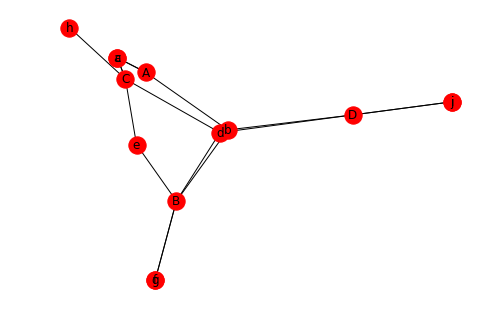

In [11]:
#nx.draw(g, with_labels = True)
#nx.draw_random(g, with_labels = True)
#nx.draw_circular(g, with_labels = True)
nx.draw_spectral(g, with_labels = True)
plt.show()

In [12]:
pos = nx.spring_layout(g)

{'A': Text(0.32701,-0.401577,'A'),
 'B': Text(-0.159418,0.404529,'B'),
 'C': Text(0.505075,0.0166246,'C'),
 'D': Text(-0.546301,-0.310972,'D'),
 'a': Text(0.621621,-0.441513,'a'),
 'b': Text(-0.141862,-0.16786,'b'),
 'c': Text(0.719445,-0.257239,'c'),
 'd': Text(-0.0752143,0.0266855,'d'),
 'e': Text(0.275675,0.388147,'e'),
 'f': Text(-0.164731,0.870407,'f'),
 'g': Text(-0.504785,0.712254,'g'),
 'h': Text(0.94439,0.20229,'h'),
 'i': Text(-1,-0.356206,'i'),
 'j': Text(-0.800905,-0.68557,'j')}

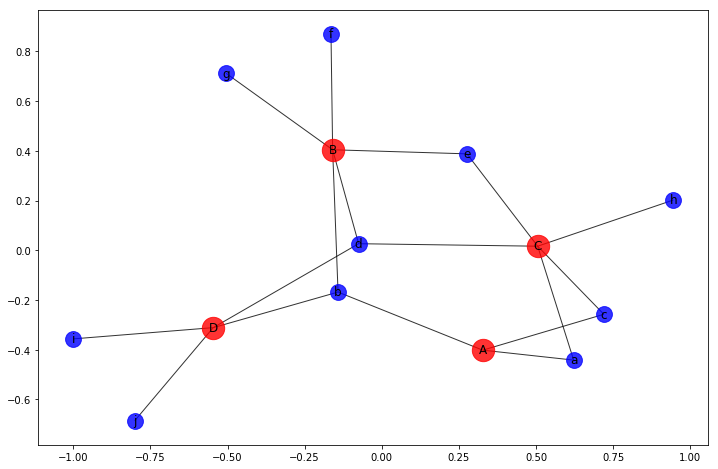

In [13]:
plt.figure(figsize = [12, 8])
nx.draw_networkx_nodes(g, pos, 
                       nodelist = list(R.keys()), 
                       node_color = 'r', 
                       node_size= 500, 
                       alpha = 0.8)
nx.draw_networkx_nodes(g, pos,
                       nodelist = items,
                       node_color = 'b',
                       node_size = 250,
                       alpha = 0.8)
nx.draw_networkx_edges(g, pos, width = 1.0, alpha = 0.8)
nx.draw_networkx_labels(g, pos)

In [14]:
def simrank(G, r=0.9, max_iter=100):
    def _is_converge(s1, s2, eps=1e-4):
        for i in s1.keys():
            for j in s1[i].keys():
                if abs(s1[i][j] - s2[i][j]) >= eps:
                    return False
        return True
    # init. vars
    sim_old = defaultdict(list)
    sim = defaultdict(list)
    for n in G.nodes():
        sim[n] = defaultdict(int)
        sim[n][n] = 1
        sim_old[n] = defaultdict(int)
        sim_old[n][n] = 0
    
    # recursively calculate simrank
    for iter_ctr in range(max_iter):
        if _is_converge(sim, sim_old):
            break
        sim_old = copy.deepcopy(sim)
        for u in G.nodes():
            for v in G.nodes():
                if u == v:
                    continue
                s_uv = 0.0
                for n_u in G.neighbors(u):
                    for n_v in G.neighbors(v):
                        s_uv += sim_old[n_u][n_v]
                sim[u][v] = (r * s_uv / (len(list(G.neighbors(u))) * len(list(G.neighbors(v)))))
    return sim

In [15]:
rank = simrank(g)

{('A', 'B'): Text(-0.277546,0.1419,'0.52'),
 ('A', 'C'): Text(-0.308895,0.022438,'0.59'),
 ('A', 'D'): Text(-0.223742,-0.335719,'0.51'),
 ('B', 'C'): Text(0.00221639,0.258506,'0.54'),
 ('B', 'D'): Text(0.0873694,-0.0996519,'0.55'),
 ('C', 'D'): Text(0.0560204,-0.219114,'0.49')}

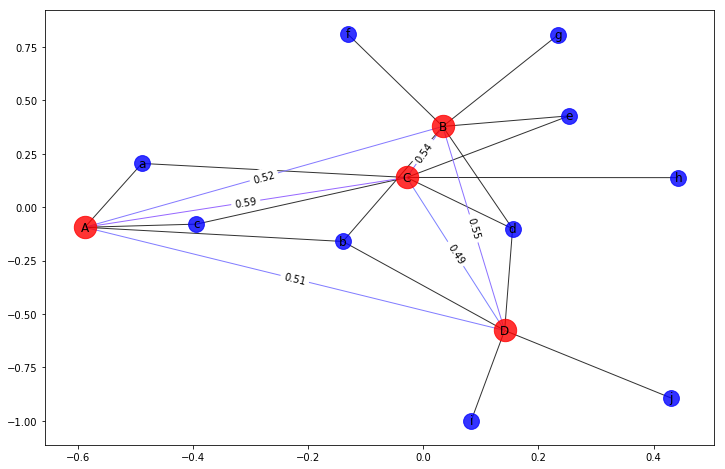

In [16]:
g_copy = g.copy()
plt.figure(figsize = [12, 8])
pos = nx.spring_layout(g_copy)
nx.draw_networkx_nodes(g_copy, pos, 
                       nodelist = list(R.keys()), 
                       node_color = 'r', 
                       node_size= 500, 
                       alpha = 0.8)
nx.draw_networkx_nodes(g_copy, pos,
                       nodelist = items,
                       node_color = 'b',
                       node_size = 250,
                       alpha = 0.8)
nx.draw_networkx_edges(g_copy, pos, width = 1.0, alpha = 0.8)
nx.draw_networkx_labels(g_copy, pos)

L = ['A', 'B', 'C', 'D']
edges_new = {}
for i in range(len(L)):
    for j in range(i + 1, len(L)):
        p1 = L[i]
        p2 = L[j]
        sim = rank[p1][p2]
        edges_new[(p1, p2)] = sim
        g_copy.add_edge(p1, p2, weight = sim)
        

nx.draw_networkx_edges(g_copy, pos, edgelist = edges_new.keys(),
                       edge_color = plt.get_cmap('cool')(list(edges_new.values())), 
                       edge_cmap = plt.get_cmap('cool'),
                       edge_vmin = 0.0,
                       edge_vmax = 1.0)
nx.draw_networkx_edge_labels(g_copy, pos, 
                             {k: ("%.2f" % (v)) for k, v in edges_new.items()})